# Movie Recommendation System

The goal of this notebook is to create a recommendation system that will give recommendations of movies based on user input.

## First look at the data

In [207]:
# Importing the datasets
import pandas as pd
import numpy as np
movies = pd.read_csv('ml-latest-small/movies.csv')
ratings = pd.read_csv('ml-latest-small/ratings.csv')

#visualization
import matplotlib.pyplot as plt
%matplotlib inline

#models
import time
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy
from surprise import Reader, Dataset
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms import knns
from surprise.prediction_algorithms import SVD
from surprise import NormalPredictor
from surprise import BaselineOnly
from surprise.prediction_algorithms import NMF
from surprise.prediction_algorithms import SlopeOne
from surprise.prediction_algorithms import CoClustering

#  Grid search and parameters
from surprise.model_selection import GridSearchCV

In [208]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [209]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


I'll be using surprise to do my prediction and modeling so I need to reduce the ratings data down to three columns. Time stamp is extraneous to begin with so I'll drop that column entirely.

In [210]:
ratings = ratings.drop(columns = 'timestamp')
ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


Perfect. Now, that we know nothing is wrong  with out data let's see what exactly the data *is*. Let's start with what the most popular genre is.

<AxesSubplot:ylabel='genres'>

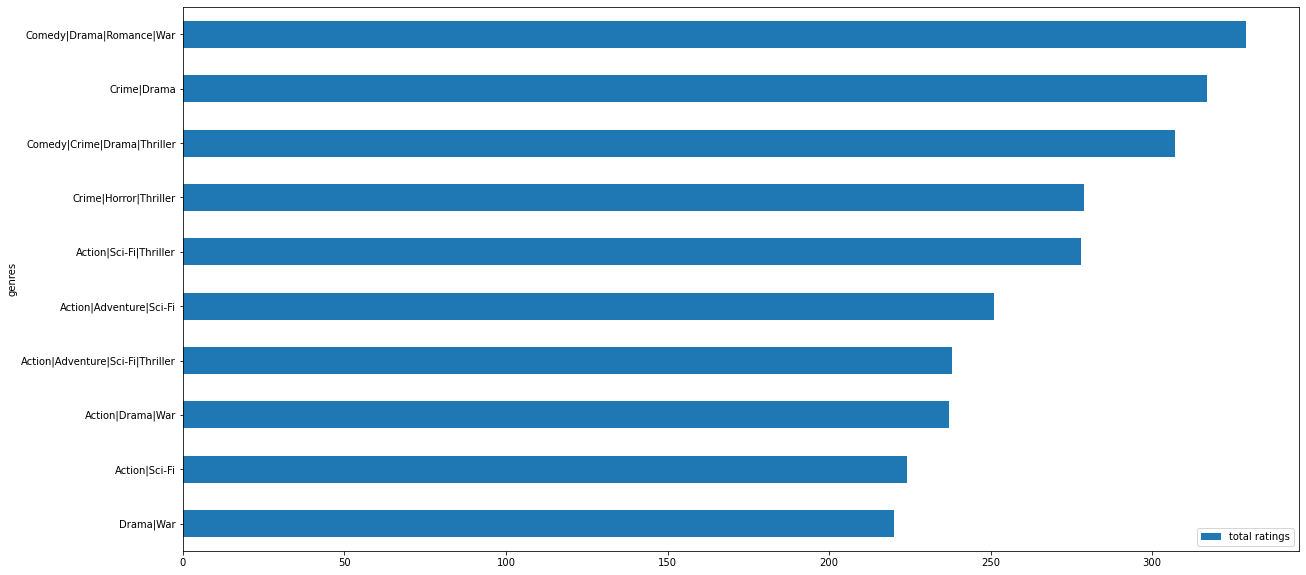

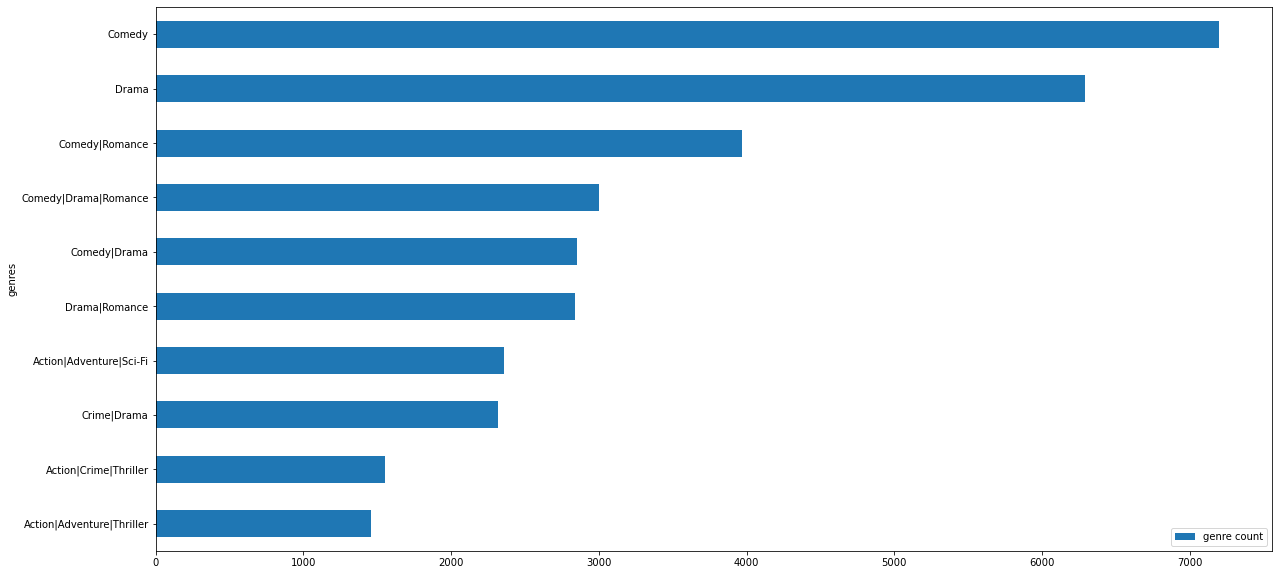

In [211]:
#setting up a new df to make visualizaations
df2 = ratings.merge(movies, on='movieId')

#new column that returns a count of every instance of the movie title
#since ever row is a different rating, ever time a movie title appears
#that would be one rating.
df2['total ratings'] = df2.groupby('title')['title'].transform('count')
#same as above but for genre types
df2['genre count'] = df2.groupby('genres')['genres'].transform('count')

#counts & plots most popular movie genres
df2TotRate = df2.drop_duplicates(subset = 'title').sort_values(by='total ratings', ascending=False).head(10)
df2TotRate = df2TotRate.sort_values(by='total ratings', ascending=True)
df2TotRate.plot('genres', 'total ratings', kind='barh', figsize = (20, 10))
#plt.savefig('images/highestRatedGenres.png')

#counts & plots most freequent movie genres
df2TotGenres = df2.drop_duplicates(subset = 'genres').sort_values(by='genre count', ascending=False).head(10)
df2TotGenres = df2TotGenres.sort_values(by='genre count', ascending=True)
df2TotGenres.plot('genres', 'genre count', kind='barh', figsize = (20, 10))
#plt.savefig('images/mostFrequentGenres.png')

In [212]:
df2TotRate

,userId,movieId,rating,title,genres,total ratings,genre count
3570,1,527,5.0,Schindler's List (1993),Drama|War,220,1044
26714,5,589,3.0,Terminator 2: Judgment Day (1991),Action|Sci-Fi,224,689
854,1,110,4.0,Braveheart (1995),Action|Drama|War,237,1034
3188,1,480,4.0,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller,238,1446
1568,1,260,5.0,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi,251,2361
12642,1,2571,5.0,"Matrix, The (1999)",Action|Sci-Fi|Thriller,278,1195
4310,1,593,4.0,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,279,340
1819,1,296,3.0,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,307,563
16296,2,318,3.0,"Shawshank Redemption, The (1994)",Crime|Drama,317,2315
2426,1,356,4.0,Forrest Gump (1994),Comedy|Drama|Romance|War,329,421


Awesome. From what I can see, Comedy and Drama seem to trade blows for top spot in both categories with Comedy being just a tad head. We'll set our default genre search to Comedy.

Next, I want to know what the average number of movies a user rates as we can set our default required input for new users.

In [213]:
#new column of every time a userId appears.
df2['total movies rated by user'] = df2.groupby(cols)['userId'].transform('size')

df2['total movies rated by user'].mean()

58.75877662739498

Yikes. That's alotta damage. I cannot ask a brand new user to rate 58 movies jsut to get started. Let's look at users who have rated 15 movies or less. From  that, we can at least assume that bellow that number, users are relatively new. We'll take the mean of that, round to the nearest, and got from there.

In [214]:
df2ratings = df2[(df2['total movies rated by user'] <= 15)]
df2ratings['total movies rated by user'].mean().round()

7.0

7 is drastically more reasonable. Fianlly, let's get into model test.

## Model Testing

In [215]:
#loading the .CSV file into surprise
reader = Reader()
data = Dataset.load_from_df(ratings,reader)
train, test = train_test_split(data, test_size=0.2)

rmseScores = []

In [216]:
# This is for checking the time it takes to run each individual model
# Running this cell might take a while

sim_pearson = {'name':'pearson', 'user_based':False}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
start = time.time()
basic_pearson.fit(train)
predictions = basic_pearson.test(test)
thePrediction = f'KNNBasic: {accuracy.rmse(predictions)}'
end = time.time()
store = f'{thePrediction} | Time Elapsed: {np.round(end - start, 2)}/sec'
rmseScores.append(store)

knn_means = knns.KNNWithMeans(sim_options=sim_pearson)
start = time.time()
knn_means.fit(train)
predictions = knn_means.test(test)
thePrediction = f'KNNWithMeans: {accuracy.rmse(predictions)}'
end = time.time()
store = f'{thePrediction} | Time Elapsed: {np.round(end - start, 2)}/sec'
rmseScores.append(store)

knnZ = knns.KNNWithZScore(sim_options=sim_pearson)
start = time.time()
knnZ.fit(train)
predictions = knnZ.test(test)
thePrediction = f'KNNWithZScore: {accuracy.rmse(predictions)}'
end = time.time()
store = f'{thePrediction} | Time Elapsed: {np.round(end - start, 2)}/sec'
rmseScores.append(store)

sim_pearson = {'name':'pearson', 'user_based':False}
knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
start = time.time()
knn_baseline.fit(train)
predictions = knn_baseline.test(test)
thePrediction = f'KNNBaseline: {accuracy.rmse(predictions)}'
end = time.time()
store = f'{thePrediction} | Time Elapsed: {np.round(end - start, 2)}/sec'
rmseScores.append(store)

svd = SVD()
start = time.time()
svd.fit(train)
predictions = svd.test(test)
thePrediction = f'SVD: {accuracy.rmse(predictions)}'
end = time.time()
store = f'{thePrediction} | Time Elapsed: {np.round(end - start, 2)}/sec'
rmseScores.append(store)

normPred = NormalPredictor()
start = time.time()
normPred.fit(train)
predictions = normPred.test(test)
thePrediction = f'NormalPredictor: {accuracy.rmse(predictions)}'
end = time.time()
store = f'{thePrediction} | Time Elapsed: {np.round(end - start, 2)}/sec'
rmseScores.append(store)

baseline = BaselineOnly()
start = time.time()
baseline.fit(train)
predictions = baseline.test(test)
thePrediction = f'BaselineOnly: {accuracy.rmse(predictions)}'
end = time.time()
store = f'{thePrediction} | Time Elapsed: {np.round(end - start, 2)}/sec'
rmseScores.append(store)

NMF = NMF()
start = time.time()
NMF.fit(train)
predictions = NMF.test(test)
thePrediction = f'NMF: {accuracy.rmse(predictions)}'
end = time.time()
store = f'{thePrediction} | Time Elapsed: {np.round(end - start, 2)}/sec'
rmseScores.append(store)

slopeOne = SlopeOne()
start = time.time()
slopeOne.fit(train)
predictions = slopeOne.test(test)
thePrediction = f'SlopeOne: {accuracy.rmse(predictions)}'
end = time.time()
store = f'{thePrediction} | Time Elapsed: {np.round(end - start, 2)}/sec'
rmseScores.append(store)

cluster = CoClustering()
start = time.time()
cluster.fit(train)
predictions = cluster.test(test)
thePrediction = f'CoClustering: {accuracy.rmse(predictions)}'
end = time.time()
store = f'{thePrediction} | Time Elapsed: {np.round(end - start, 2)}/sec'
rmseScores.append(store)

rmseScores

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9720
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9029
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.9074
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8812
RMSE: 0.8755
RMSE: 1.4372
Estimating biases using als...
RMSE: 0.8764
RMSE: 0.9257
RMSE: 0.9028
RMSE: 0.9425


['KNNBasic: 0.9720369251140125 | Time Elapsed: 24.31/sec',
 'KNNWithMeans: 0.9028617434197561 | Time Elapsed: 24.49/sec',
 'KNNWithZScore: 0.9073671599037757 | Time Elapsed: 23.85/sec',
 'KNNBaseline: 0.8812415946219455 | Time Elapsed: 23.75/sec',
 'SVD: 0.8755218323022746 | Time Elapsed: 3.59/sec',
 'NormalPredictor: 1.4372195029014587 | Time Elapsed: 0.25/sec',
 'BaselineOnly: 0.8763716172374532 | Time Elapsed: 0.27/sec',
 'NMF: 0.925673436840378 | Time Elapsed: 4.37/sec',
 'SlopeOne: 0.9028341523589599 | Time Elapsed: 8.44/sec',
 'CoClustering: 0.9424730749427819 | Time Elapsed: 2.38/sec']

SVD and BaselineOnly seems to have the closest accuracy while maintaining a very short runtime. Although KNNBaseline has the second best score, all KNN models have a substantial runtime that holds it back. Looking at BaselineOnly, modifying the parameters seems to be missing some documentation.

Let's commit to SVD and run a grid search to narrow in what parameters might work best.

In [217]:
params = {'n_factors': [20, 50, 100], 'reg_all': [0.02, 0.05, 0.1]}
GSsvd = GridSearchCV(SVD, param_grid = params, n_jobs = -1)

In [218]:
#fitting it on the data
GSsvd.fit(data)

In [219]:
# print out optimal parameters for SVD after GridSearchbest_params
print(GSsvd.best_score)
print(GSsvd.best_params)

{'rmse': 0.8690208460870353, 'mae': 0.6681260759870858}
{'rmse': {'n_factors': 20, 'reg_all': 0.02}, 'mae': {'n_factors': 20, 'reg_all': 0.02}}


Perfect. Finally, let's build one solid function that takes in some input, runs our model, spits out some recommendations of movies.

In [220]:
# This function will take in the predictions and give the top recommendations.
# This function is separate because it'll be called in the next fucntion.
def recommended_movies(user_ratings,movie_title_df,n):
    for idx, rec in enumerate(user_ratings):
        title = movie_title_df.loc[movie_title_df['movieId'] == int(rec[0])]['title']
        print('Recommendation # ', idx+1, ': ', title, '\n')
        n -= 1
        if n == 0:
            break

# This portion will take the ratings list and 2 empty, makes a prediction, and appends it to the empty lists
def predict(dfList, emptyList, emptyList2):
    new_rating_df = dfList.append(emptyList, ignore_index = True)
    new_data = Dataset.load_from_df(new_rating_df, reader)
    svd = SVD(n_factors=100, n_epochs=10, lr_all=0.005, reg_all=0.4)
    svd.fit(new_data.build_full_trainset())
    predictions = svd.test(test)
    #thePrediction = accuracy.rmse(predictions)

    for m_id in new_rating_df['movieId'].unique():
        emptyList2.append((m_id, svd.predict(1000, m_id)[3]))

In [221]:
def movie_recommender(num_of_rated_movies, genre=None):
    userID = 1000
    rating_list = []
    movies_list = []
    
    newMovies = ratings.merge(movies, on='movieId')
    newMovies['total ratings'] = df2.groupby('title')['title'].transform('count')
    print(f'Thank you for participating! In order to obtain your recommendations, please rate {num_of_rated_movies} movies.')
    
    #determines if the user wants a specific genre or not and gives random examples to rate accordingly.
    #exaamples are given based on top 100 of the determined list
    while num_of_rated_movies > 0:
        if genre:
            dropping = newMovies.drop_duplicates(subset = 'title').sort_values(by='total ratings', ascending=False).head(100)
            sorting = dropping[dropping['genres'].str.contains(genre)]
            organizing = sorting.sort_values(by='total ratings', ascending=True)
            last_drop = organizing.drop(columns = ['total ratings'])
            movie = last_drop.sample(1)
        else:
            newgenre = movies['genres']
            
            dropping = newMovies.drop_duplicates(subset = 'title').sort_values(by='total ratings', ascending=False).head(100)
            organizing = dropping.sort_values(by='total ratings', ascending=True)
            last_drop = organizing.drop(columns = ['total ratings'])
            movie = last_drop.sample(1)
        print(movie)
        #takes user put and appends it to empty list for later use.
        rating = input('On a scale of 1 - 5, how would you rate this movie? press n if you have not seen this movie. Press enter to submit your answer: \n')
        if rating == 'n':
            continue
        else:
            rating_one_movie = {'userId':userID, 'movieId':movie['movieId'].values[0], 'rating':rating}
            rating_list.append(rating_one_movie)
            num_of_rated_movies -= 1

    #again, determines the user specified a genre or not.
    if genre:
        #movie df of specicied genre
        newMovies = newMovies[newMovies['genres'].str.contains(genre)]
        newMovies = newMovies.drop(columns = ['title', 'genres', 'total ratings'])
        
        predict(newMovies, rating_list, movies_list)

        # This portion takes the list of predictions and orders them in order
        # of most likely to be liked by the user to least.
        ranked_movies = sorted(movies_list, key=lambda x:x[1], reverse=True)
    else:
        predict(ratings, rating_list, movies_list)
        ranked_movies = sorted(movies_list, key=lambda x:x[1], reverse=True)
    
    # This takes in the list of predicted movies, the DataFrame of movies,
    # and a number for how many movies to show (starting from the top)
    return (recommended_movies(ranked_movies,movies,5))

In [222]:
#### Running this cell will start the questionair.
# It takes in the DataFrame of movies, a number for how many user inputs
# it requires, and the genre you wish to get recommendations from
movie_recommender(7, 'Comedy')

Thank you for participating! In order to obtain your recommendations, please rate 7 movies.
       userId  movieId  rating         title  \
32865       6      587     5.0  Ghost (1990)   

                                      genres  
32865  Comedy|Drama|Fantasy|Romance|Thriller  
On a scale of 1 - 5, how would you rate this movie? press n if you have not seen this movie. Press enter to submit your answer: 
n
       userId  movieId  rating           title  \
19939       4      588     4.0  Aladdin (1992)   

                                            genres  
19939  Adventure|Animation|Children|Comedy|Musical  
On a scale of 1 - 5, how would you rate this movie? press n if you have not seen this movie. Press enter to submit your answer: 
5
       userId  movieId  rating  \
37588       7     6539     4.5   

                                                   title  \
37588  Pirates of the Caribbean: The Curse of the Bla...   

                                genres  
37588  Action|Adv

The use cases for this are ultimately pretty obvious. Movie streaming services are all but uncommon. Movie streaming services like Hulu and Netflix require user input to be able to recommend movies to users effectively. Even if it's as simple as recommendations base on movies similar to the most recent.

This system could work in tandem, using a 'likes' system to recommend movies upfront could help jumpstart streaming services give something accurate to begin with.